In [1]:
from typing import List, Tuple
from enum import Enum
import seaborn as sns
import os
import pandas as pd
import json
import numpy as np
from statistics import mean, stdev
import matplotlib.pyplot as plt

In [2]:
class DetectionAlgorithmsNames(Enum):
    """
    Enum class for the detection algorithms
    """
    LOUV = "louvain"
    WALK = "walktrap"
    GRE = "greedy"

class FilePaths(Enum):
    """Class to store file paths for data and models"""

    # ° Local
    DATASETS_DIR = "dataset/data"
    LOG_DIR = "src/logs/"
    TEST_DIR = "test/"

    # USED DATASETS
    KAR = DATASETS_DIR + "/kar.mtx"
    WORDS = DATASETS_DIR + "/words.mtx"
    VOTE = DATASETS_DIR + "/vote.mtx"
    FB_75 = DATASETS_DIR + "/fb-75.gml"
    POW = DATASETS_DIR + "/pow.gml"

In [3]:
def check_dir(path: str):
        """
        Check if the directory exists, if not create it.

        Parameters
        ----------
        path : str
            Path to the directory
        """
        if not os.path.exists(path):
            os.makedirs(path)

# F1 SCORE

In [4]:
def plot_f1_all_datasets(
            datasets: List[str], 
            detection_algs: List[str],
            taus: List[float],
            betas: List[float]
            ):
        """
        Plot the f1 scores of the evaluation on all the datasets and detection algorithms

        Parameters
        ----------
        datasets : List[str]
            List of datasets
        detection_algs : List[str]
            List of detection algorithms
        taus : List[float]
            List of tau values
        betas : List[float]
            List of beta values
        """

        datasets_names = {
            FilePaths.KAR.value: "kar",
            FilePaths.WORDS.value: "words",
            FilePaths.VOTE.value: "vote",
            FilePaths.POW.value: "pow",
            FilePaths.FB_75.value: "fb",
        }

        save_path = "../test_review/all_datasets/f1_score/"
        check_dir(save_path)
        log_name = "evaluation_node_hiding"

        agent_renamed = "DRL-Agent"
        centrality_renamed = "Betweenness"
        dcmh_renamed = "DCMH (ours)"

        evading_algs=["DCMH","Agent","Random","Degree","Centrality","Roam","Greedy"]
        metric = "F1 score"

        datasets = [datasets_names[dataset] for dataset in datasets]

        f1_dict = {}
        for dataset in datasets:
            f1_dict[dataset] = {}
            for detection_alg in detection_algs:
                f1_dict[dataset][detection_alg] = {}
                for tau in taus:
                    f1_dict[dataset][detection_alg][f"tau_{tau}"] = {}
                    for beta in betas:
                        f1_dict[dataset][detection_alg][f"tau_{tau}"][f"beta_{beta}"] = {}
                        json_path = f"../test_review/{dataset}/{detection_alg}/node_hiding/tau_{tau}/beta_{beta}/{log_name}.json"
                        with open(json_path, "r") as f:
                            log = json.load(f)
                        for alg in evading_algs:
                            f1_dict[dataset][detection_alg][f"tau_{tau}"][f"beta_{beta}"][alg] = [
                                (2 * x * y) / (x + y)
                                for x, y in zip(log[alg]["goal"], log[alg]["nmi"])
                            ]


        for detection_alg in detection_algs:
            for tau in taus:
                for beta in betas:
                    plot_data = []
                    for dataset in datasets:
                        df = pd.DataFrame(f1_dict[dataset][detection_alg][f"tau_{tau}"][f"beta_{beta}"])
                        plot_data.append(df)
                    df = pd.concat(plot_data,axis=1)
                    # in algs list replace "Agent" with "DRL-Agent"
                    evading_algs = [agent_renamed if alg == "Agent" else alg for alg in evading_algs]
                    # in algs list replace "Centrality" with "Betweenness"
                    evading_algs = [centrality_renamed if alg == "Centrality" else alg for alg in evading_algs]
                    # in algs list replace "DCMH" with "DCMH (ours)"
                    evading_algs = [dcmh_renamed if alg == "DCMH" else alg for alg in evading_algs]
                    df.columns = pd.MultiIndex.from_product([datasets, evading_algs])
                    # Melt the dataframe
                    df = df.melt(var_name=["Dataset", "Algorithm"], value_name=metric)


                    sns.set_theme(style="darkgrid")
                    palette = sns.set_palette("Set2")
                    g = sns.catplot(
                        data=df,
                        kind="bar",
                        x="Dataset",
                        y=metric,
                        hue="Algorithm",
                        aspect=2,
                        palette=palette,
                        errorbar='ci',
                        ci=90
                    )
                    g.set_axis_labels("Datasets", f"Mean {metric.capitalize()}", fontsize=15)
                    sns.move_legend(g, "upper right", bbox_to_anchor=(1, 0.7), frameon=False)
                    g.set_xticklabels(rotation=45, ha="center", fontsize=18)
                    save_fig_path = f"{save_path}/{detection_alg}/tau_{tau}/beta_{beta}"
                    check_dir(save_fig_path)
                    g.savefig(
                        f"{save_fig_path}/f1_score_grouped.png",
                        bbox_inches="tight",
                        dpi=300,
                    )

# COMPUTATIONAL TIME

In [5]:
def plot_time_all_datasets(
            datasets: List[str], 
            detection_algs: List[str],
            taus: List[float],
            betas: List[float]
            ):
        """
        Plot the time of the evaluation on all the datasets and detection algorithms

        Parameters
        ----------
        datasets : List[str]
            List of datasets
        detection_algs : List[str]
            List of detection algorithms
        taus : List[float]
            List of tau values
        betas : List[float]
            List of beta values
        """

        datasets_names = {
            FilePaths.KAR.value: "kar",
            FilePaths.WORDS.value: "words",
            FilePaths.VOTE.value: "vote",
            FilePaths.POW.value: "pow",
            FilePaths.FB_75.value: "fb",
        }

        dataset_sizes = {
            "kar": 34+78,
            "words": 112+425,
            "vote": 889+2900,
            "pow": 4941+6954,
            "fb": 6386+217662,
        }

        save_path = "../test_review/all_datasets/time/"
        check_dir(save_path)
        log_name = "evaluation_node_hiding"


        evading_algs=["Agent","DCMH"]
        metric = "Time"

        datasets = [datasets_names[dataset] for dataset in datasets]

        time_dict = {}
        for dataset in datasets:
            time_dict[dataset] = {}
            for detection_alg in detection_algs:
                time_dict[dataset][detection_alg] = {}
                for tau in taus:
                    time_dict[dataset][detection_alg][f"tau_{tau}"] = {}
                    for beta in betas:
                        time_dict[dataset][detection_alg][f"tau_{tau}"][f"beta_{beta}"] = {}
                        json_path = f"../test_review/{dataset}/{detection_alg}/node_hiding/tau_{tau}/beta_{beta}/{log_name}.json"
                        with open(json_path, "r") as f:
                            log = json.load(f)
                        for alg in evading_algs:
                            time_dict[dataset][detection_alg][f"tau_{tau}"][f"beta_{beta}"][alg] = {
                                "mean": mean(log[alg]["time"]),
                                "std": stdev(log[alg]["time"]),
                            }

        x_values = [dataset_sizes[dataset] for dataset in datasets]
        palette = sns.color_palette("Set2")
        
        dcmh_color = palette[0]
        agent_color = palette[1]

        for detection_alg in detection_algs:
            for tau in taus:
                for beta in betas:
                    plot_data=[]
                    for dataset in datasets:
                        dict = time_dict[dataset][detection_alg][f"tau_{tau}"][f"beta_{beta}"]
                        plot_data.append(dict)
                    time_agent_mean = np.array([dict["Agent"]["mean"] for dict in plot_data])
                    #time_agent_std = np.array([dict["Agent"]["std"] for dict in plot_data])
                    time_dcmh_mean = np.array([dict["DCMH"]["mean"] for dict in plot_data])
                    #time_dcmh_std = np.array([dict["DCMH"]["std"] for dict in plot_data])

                    sns.set_theme(style="darkgrid")
                    plt.figure(figsize=(14, 10))
                    plt.scatter(x_values, time_dcmh_mean,label='DCMH (ours)', s=200, marker='s', color=dcmh_color)
                    plt.plot(x_values, time_dcmh_mean, 'r--',color=dcmh_color, linewidth=0.5, alpha=0.5)
                    plt.scatter(x_values, time_agent_mean,label='DRL-Agent', s=200, marker='^', color=agent_color)
                    plt.plot(x_values, time_agent_mean, 'r--', color=agent_color,linewidth=0.5, alpha=0.5)
                    plt.loglog()
                    plt.ylim(0.0001,1000)
                    plt.xlabel('Network size (|V|+|E|)',fontsize=20)
                    plt.ylabel('Mean Evading Time (s)',fontsize=20)
                    custom_labels = ["kar(0.11k)", "words(0.54k)", "vote(3.79k)", "pow(11.5k)", "fb(224k)"]
                    #custom_labels = ["kar (0.03k)", "words (0.11k)", "vote (0.89k)", "pow (4.9k)"]
                    plt.xticks(ticks=x_values, labels=custom_labels,rotation=45,ha="center", fontsize=15)
                    plt.legend(fontsize=20)
                    plt.grid(True)
                    save_fig_path = f'{save_path}/{detection_alg}/tau_{tau}/beta_{beta}'
                    check_dir(save_fig_path)
                    plt.savefig(f'{save_fig_path}/evading_time_grouped.png', format='png', dpi=300, bbox_inches="tight") 

# FUNCTION CALLS

/tmp/ipykernel_302494/1377188313.py:83: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 90)` for the same effect.

  g = sns.catplot(
/tmp/ipykernel_302494/1377188313.py:83: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 90)` for the same effect.

  g = sns.catplot(
/tmp/ipykernel_302494/1377188313.py:83: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 90)` for the same effect.

  g = sns.catplot(
/tmp/ipykernel_302494/1377188313.py:83: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 90)` for the same effect.

  g = sns.catplot(
/tmp/ipykernel_302494/1377188313.py:83: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 90)` for the same effect.

  g = sns.catplot(
/tmp/ipykernel_302494/1377188313.py:83: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 90)` for the same effect.

  g = sns.catplot(
/tmp/ipykernel_302494/1377188313.py:83: FutureWarnin

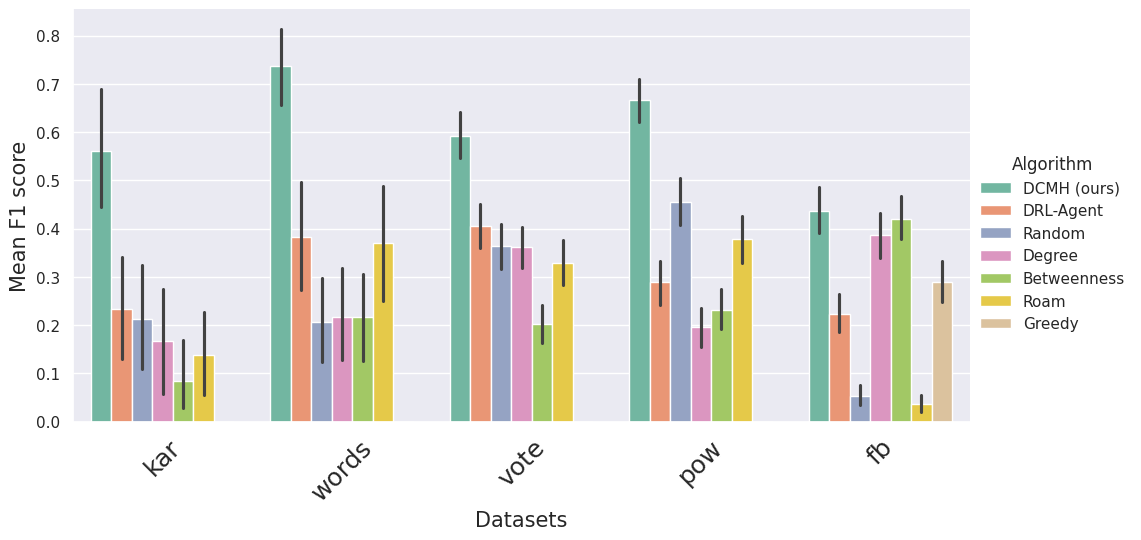

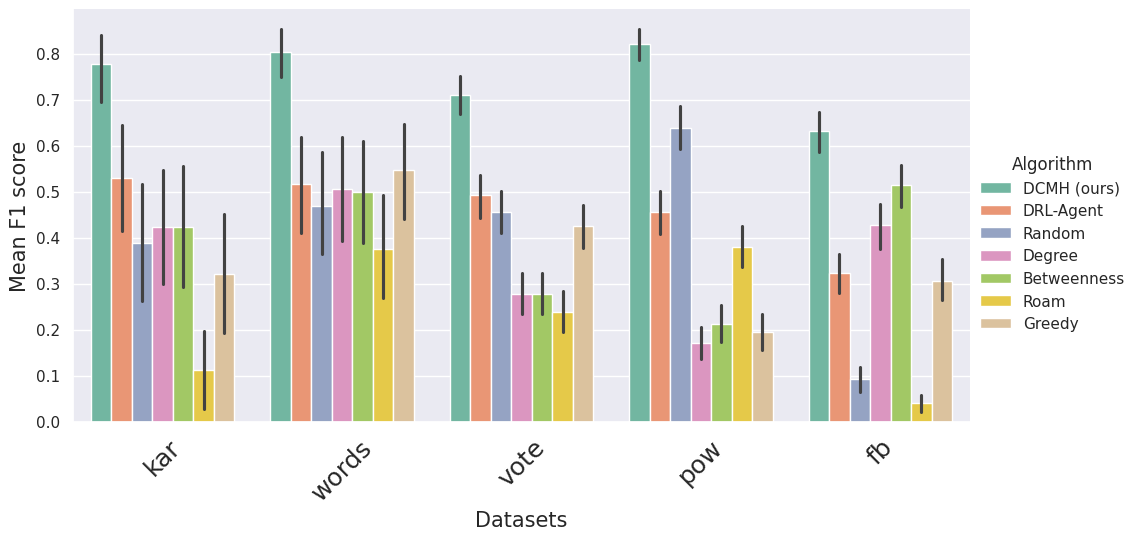

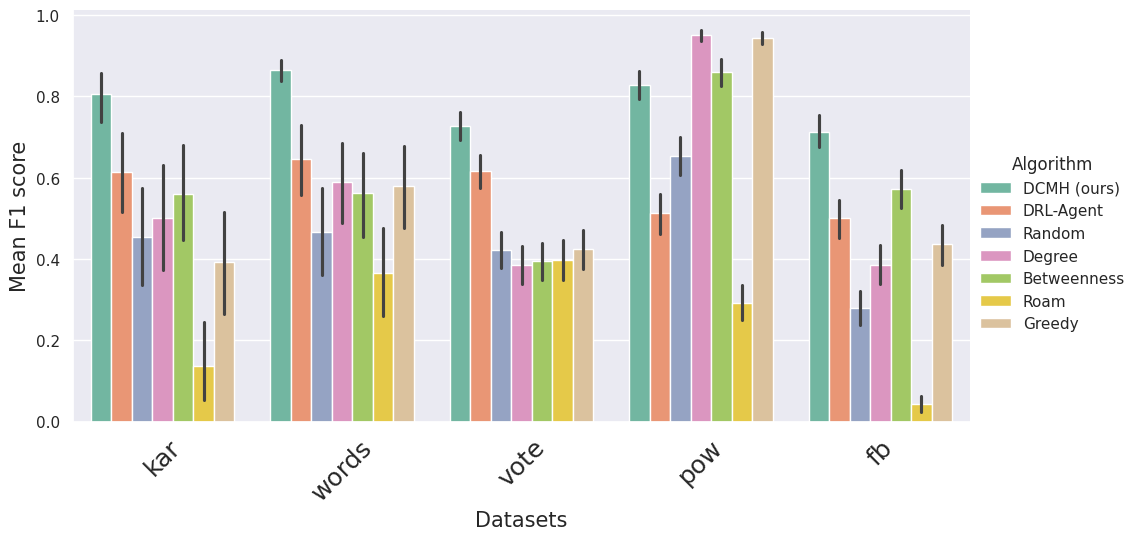

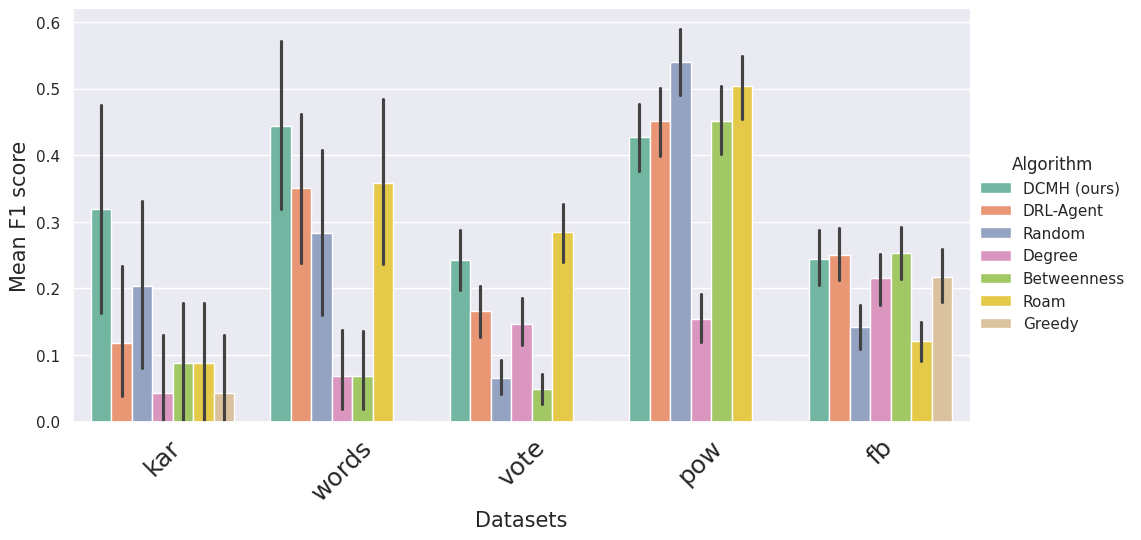

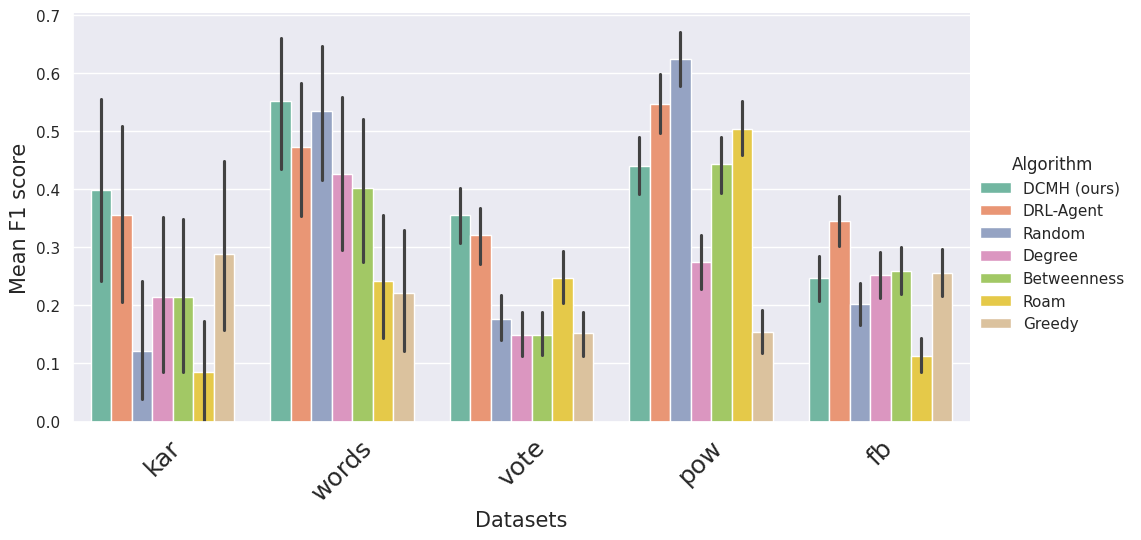

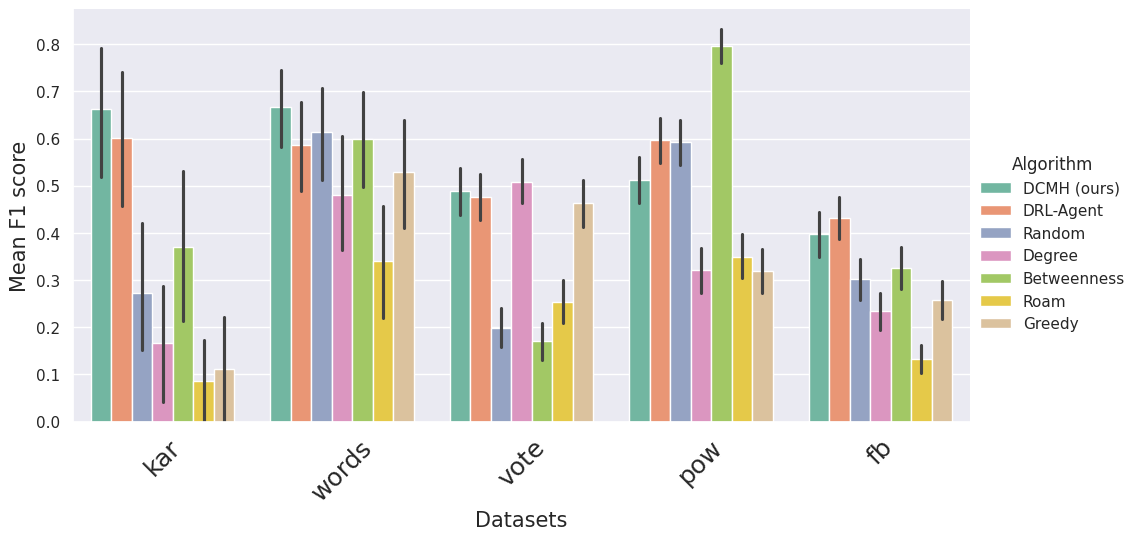

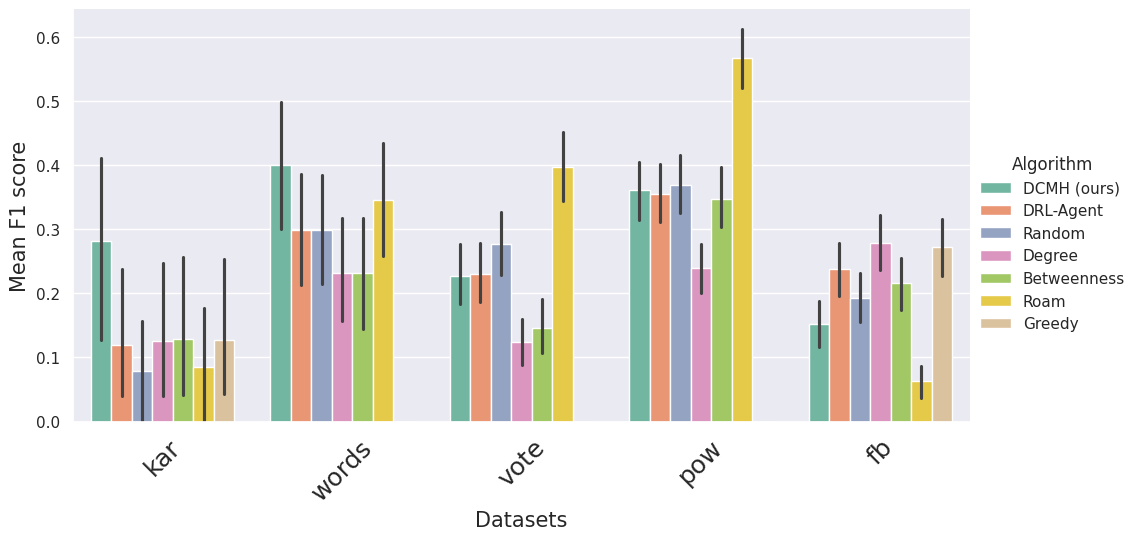

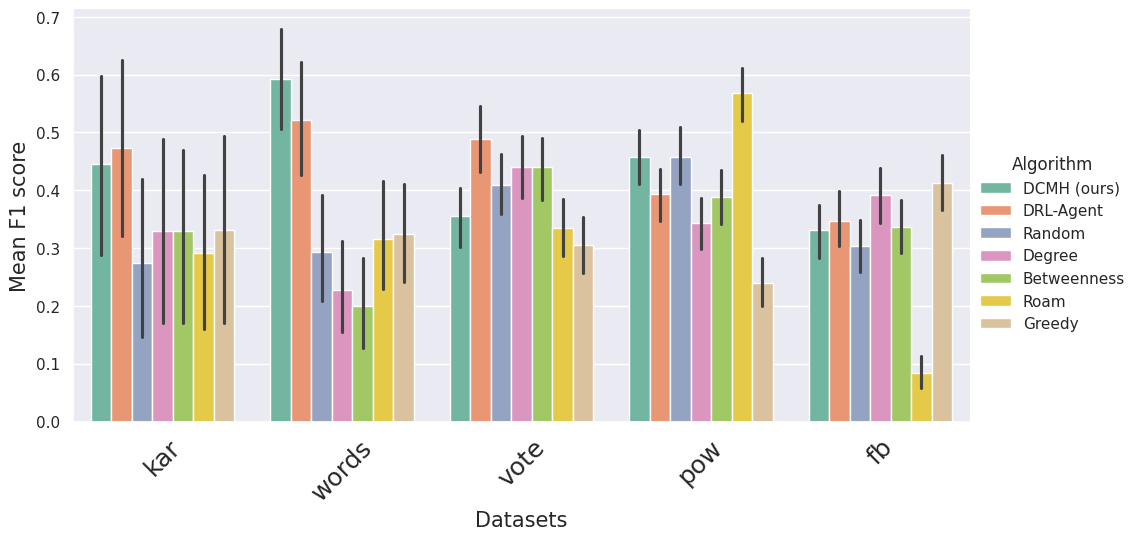

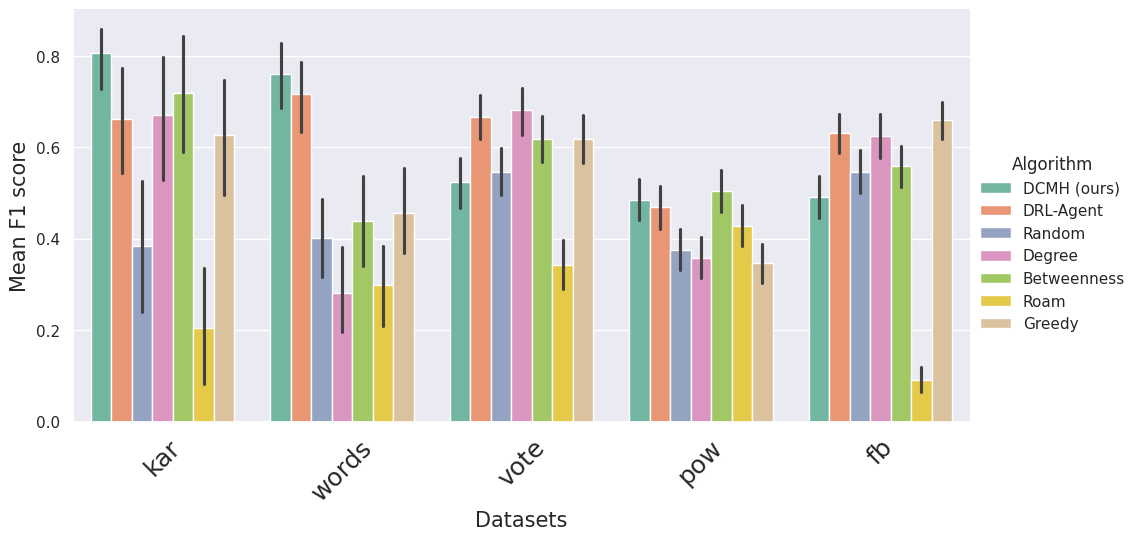

In [6]:
plot_f1_all_datasets(
            datasets= [FilePaths.KAR.value,FilePaths.WORDS.value, FilePaths.VOTE.value, FilePaths.POW.value, FilePaths.FB_75.value],
            detection_algs= [ DetectionAlgorithmsNames.GRE.value, DetectionAlgorithmsNames.LOUV.value,DetectionAlgorithmsNames.WALK.value],
            taus=[0.5],
            betas=[0.5,1,2],
        )

/tmp/ipykernel_281169/3654471023.py:87: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r--" (-> color='r'). The keyword argument will take precedence.
  plt.plot(x_values, time_dcmh_mean, 'r--',color=dcmh_color, linewidth=0.5, alpha=0.5)
/tmp/ipykernel_281169/3654471023.py:89: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r--" (-> color='r'). The keyword argument will take precedence.
  plt.plot(x_values, time_agent_mean, 'r--', color=agent_color,linewidth=0.5, alpha=0.5)
/tmp/ipykernel_281169/3654471023.py:87: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r--" (-> color='r'). The keyword argument will take precedence.
  plt.plot(x_values, time_dcmh_mean, 'r--',color=dcmh_color, linewidth=0.5, alpha=0.5)
/tmp/ipykernel_281169/3654471023.py:89: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r--" (-> 

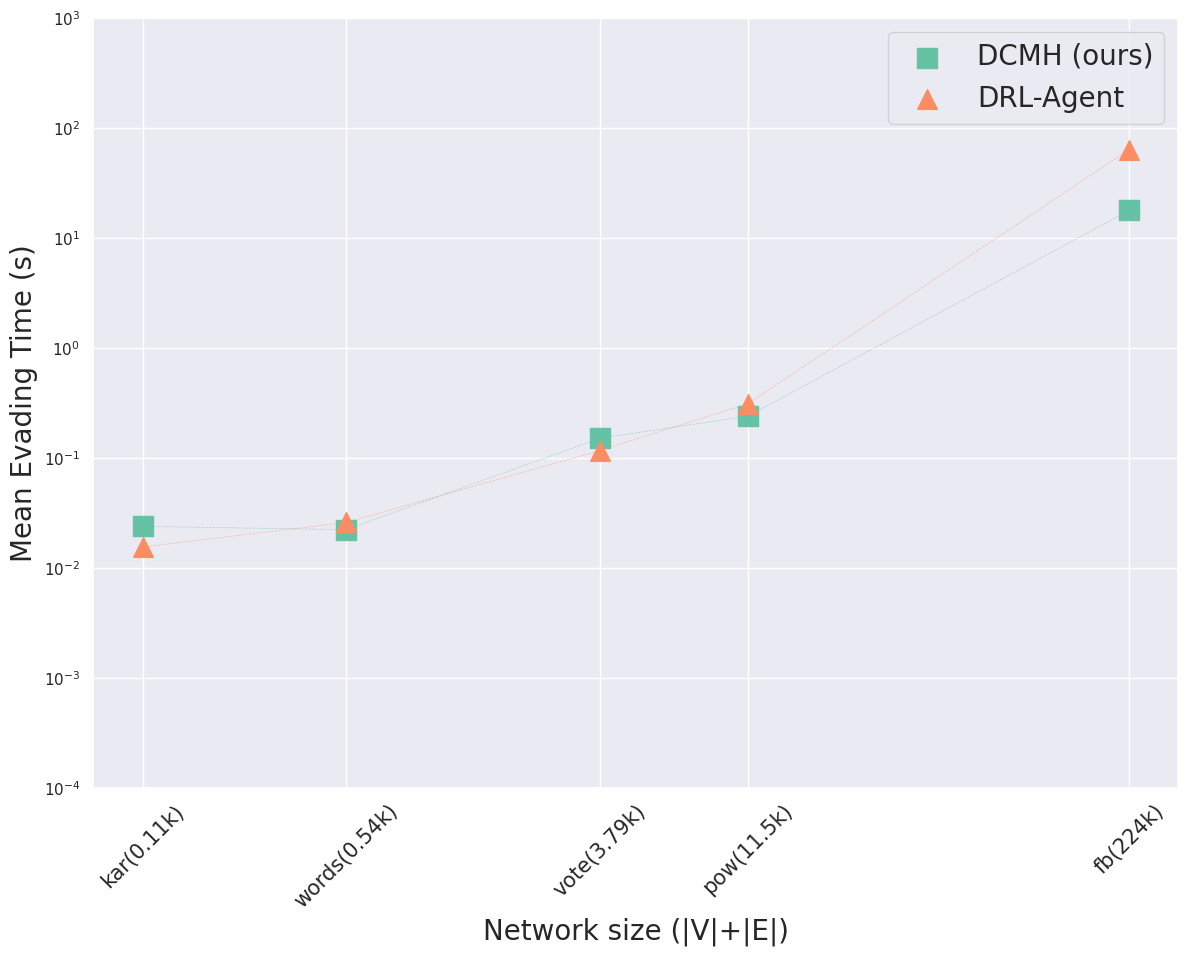

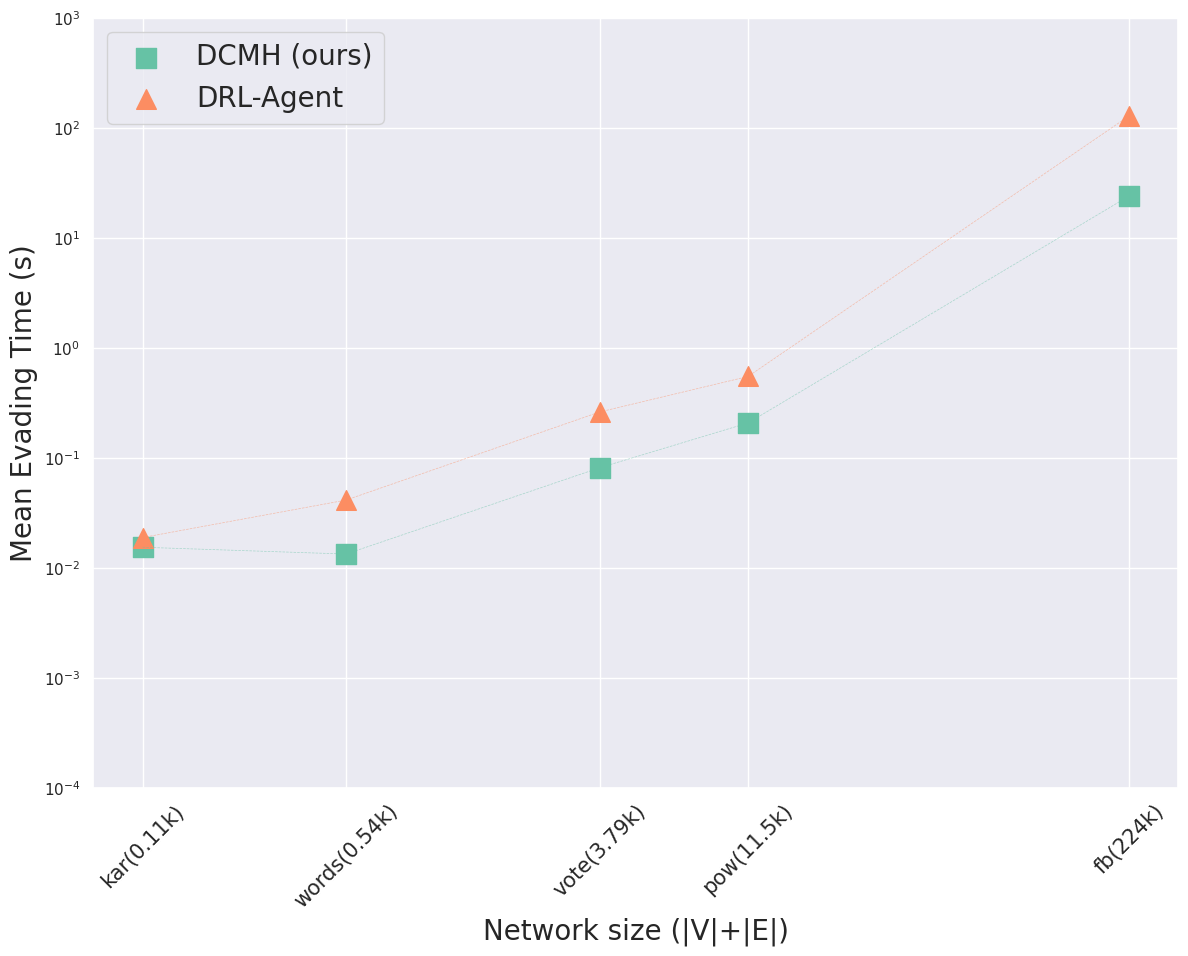

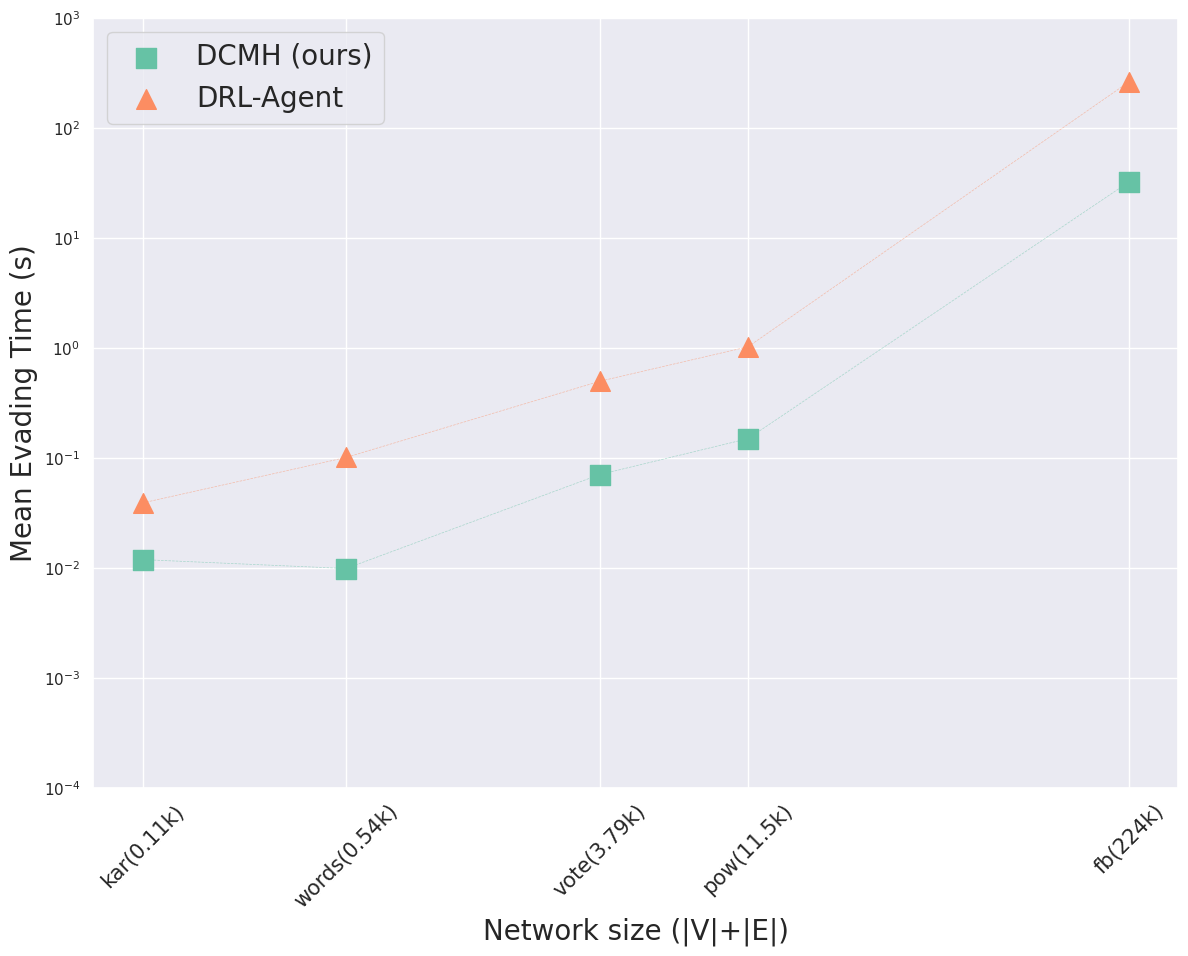

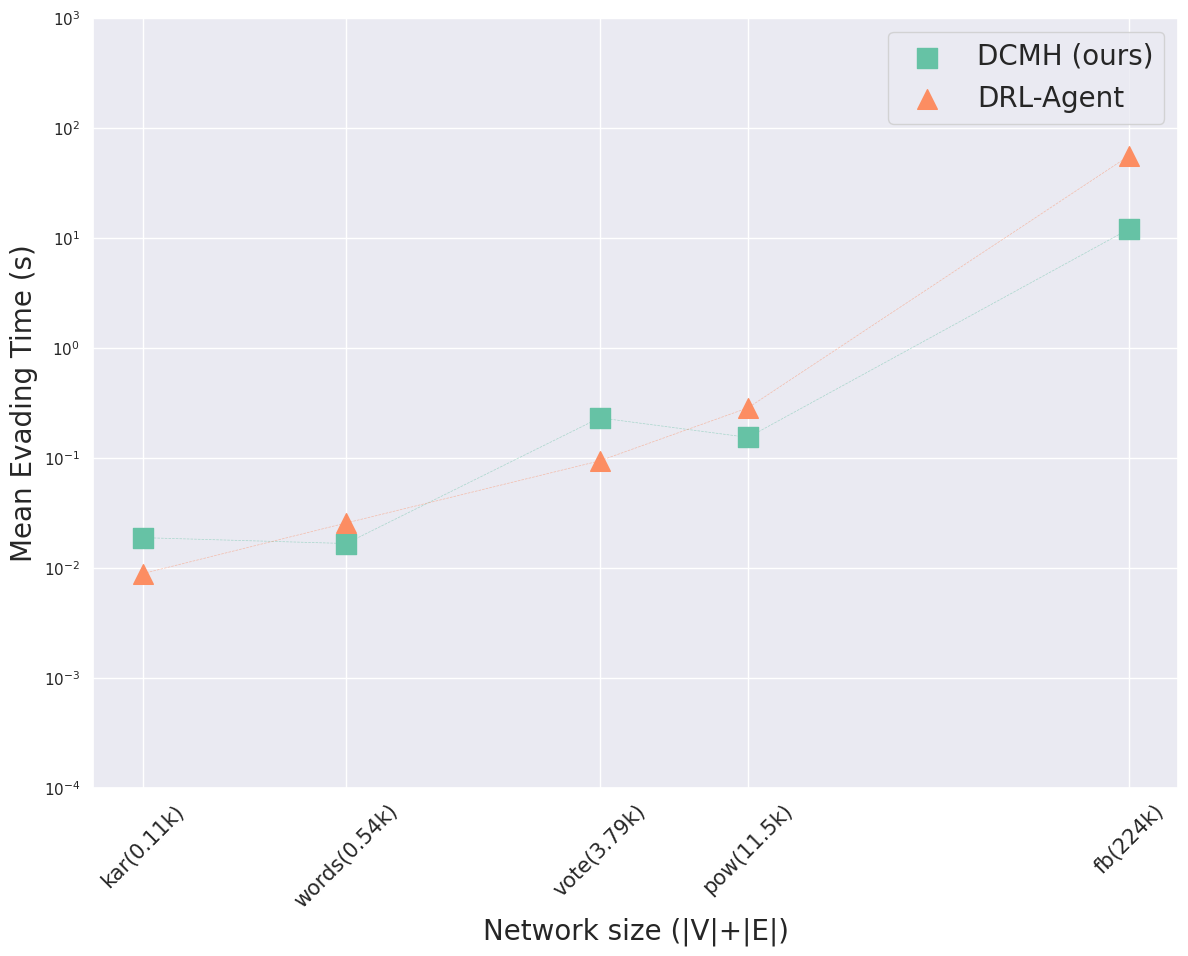

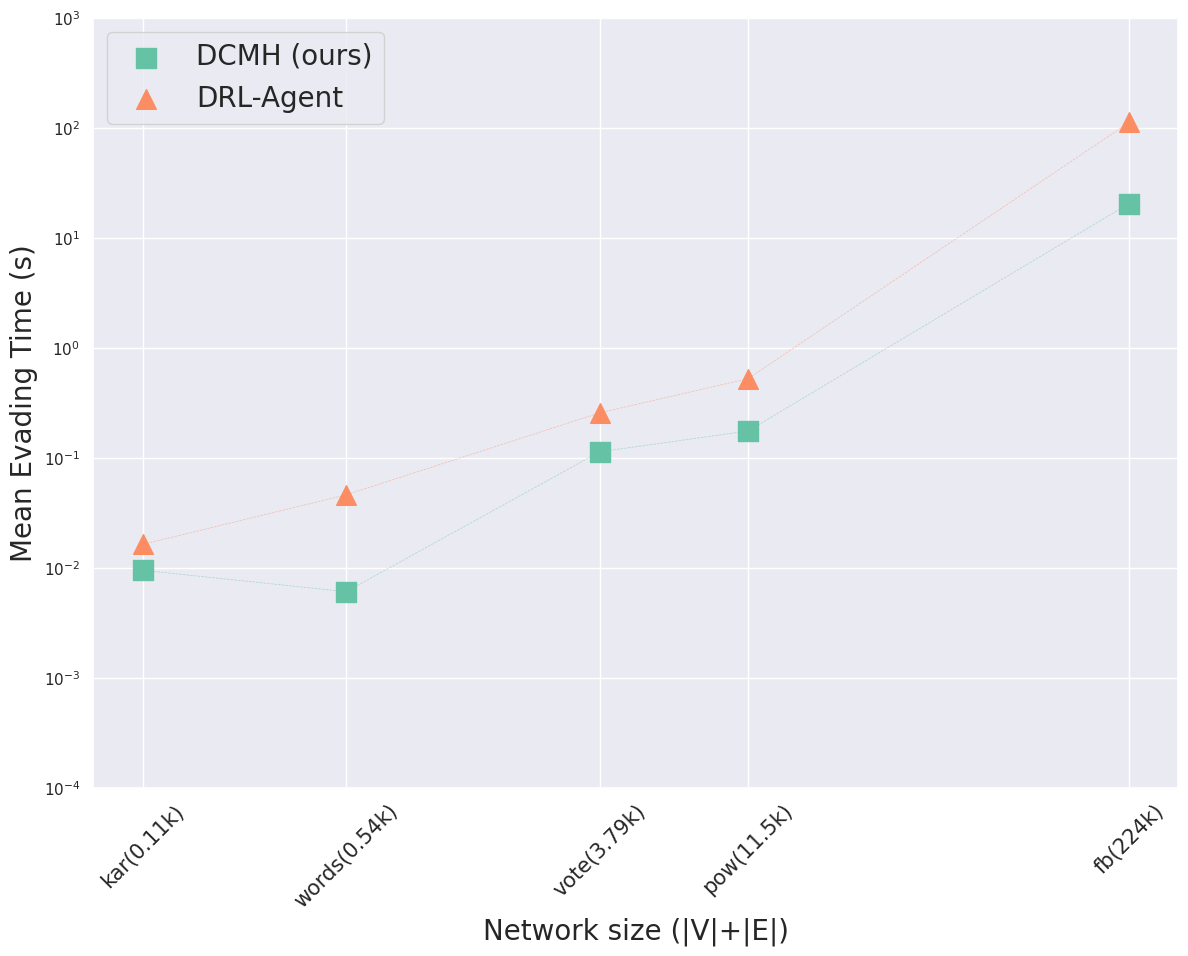

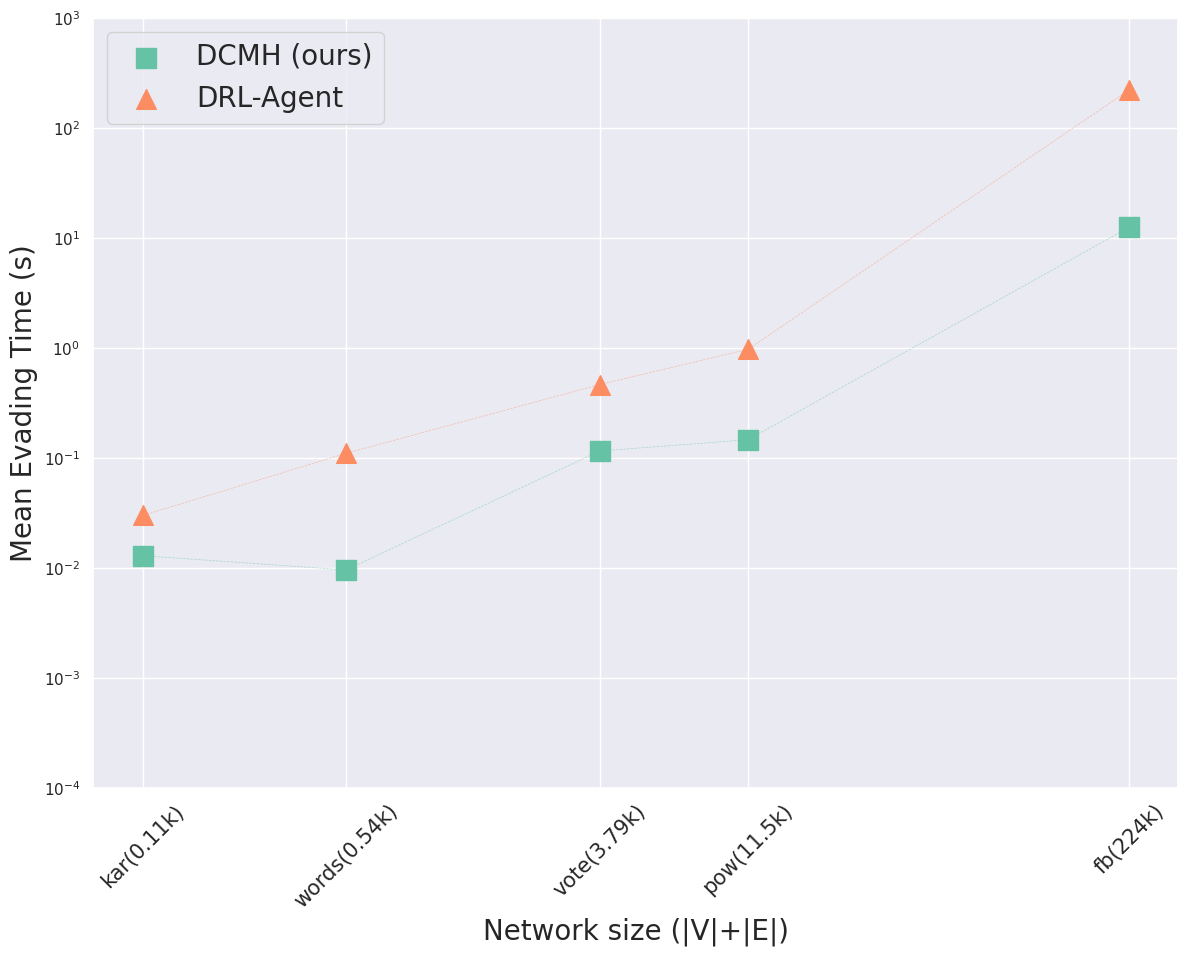

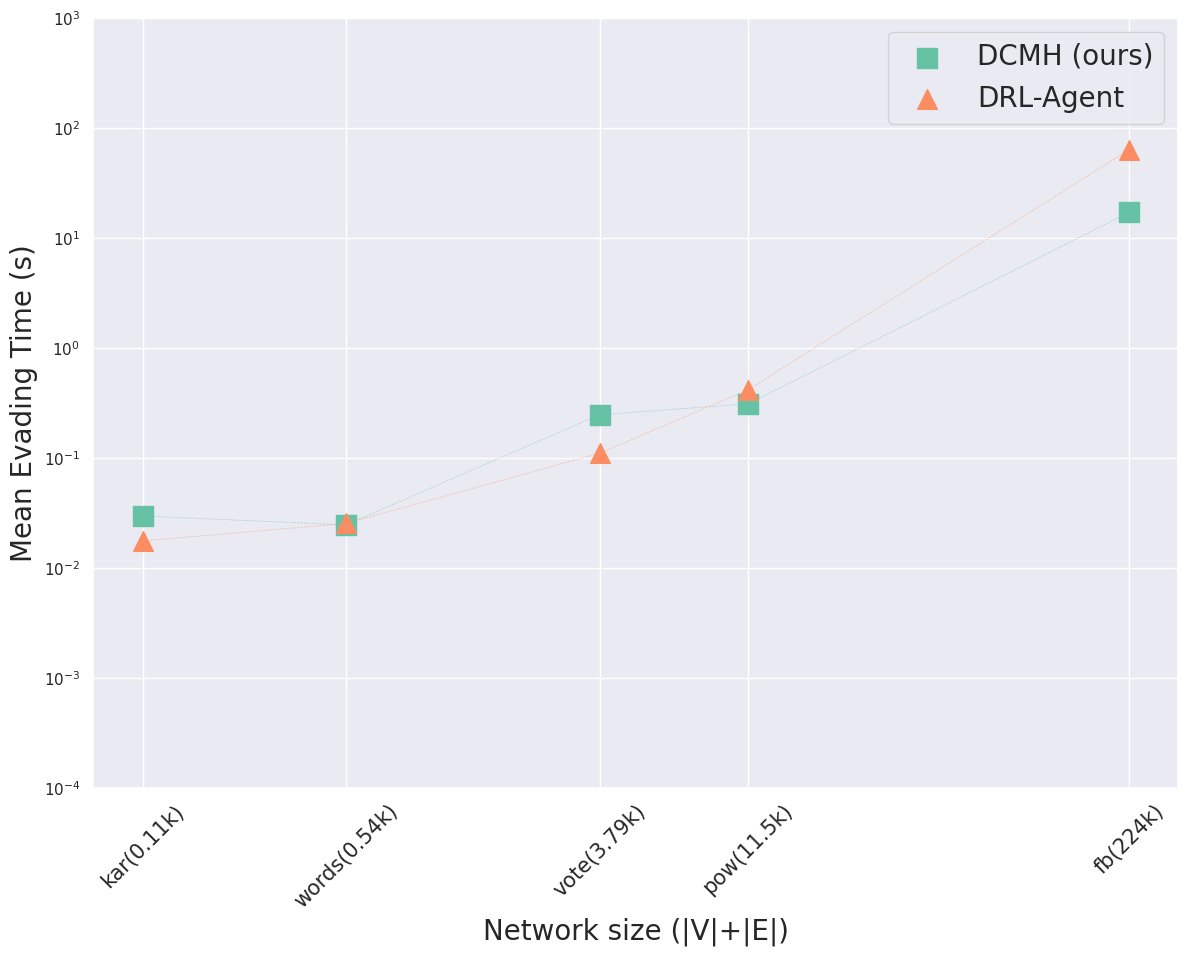

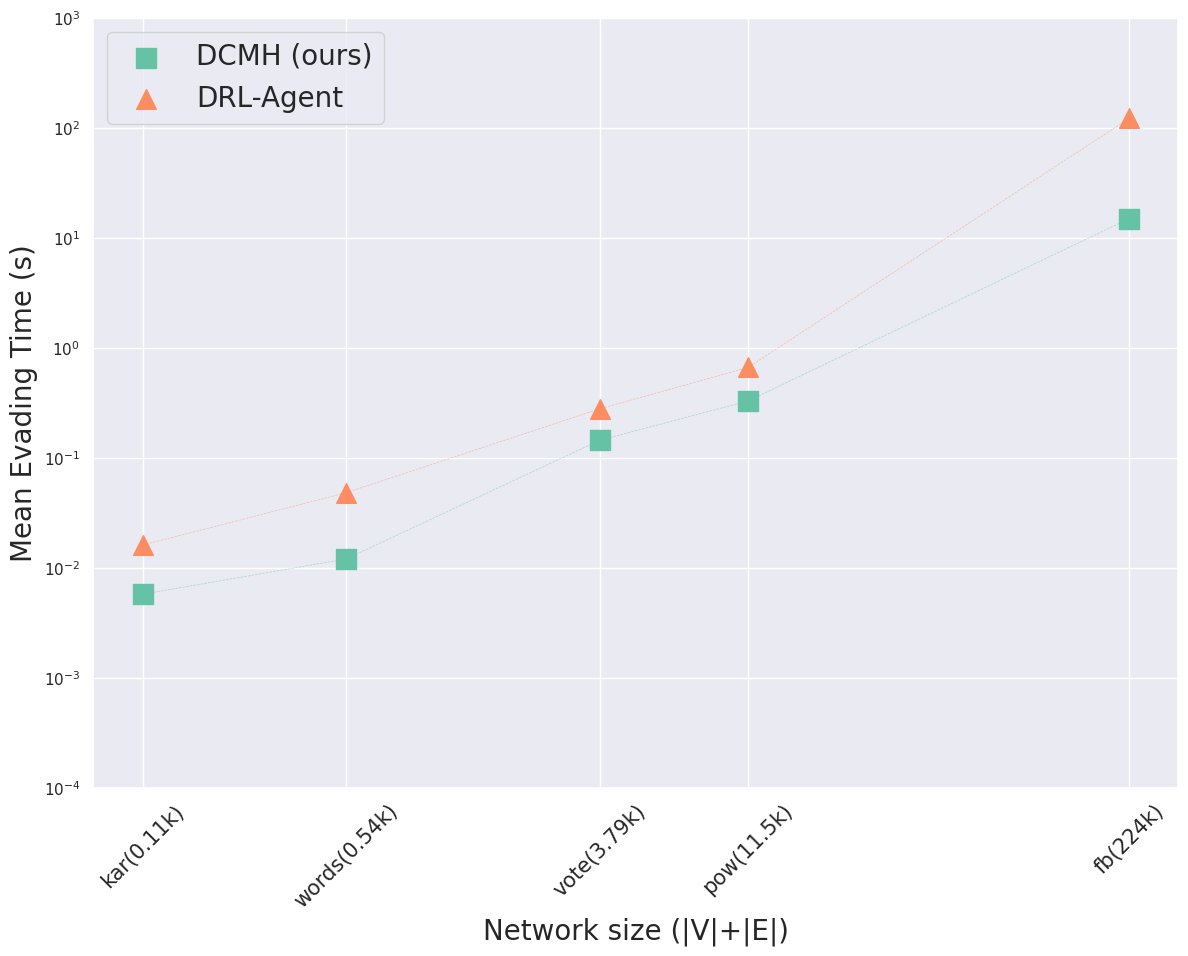

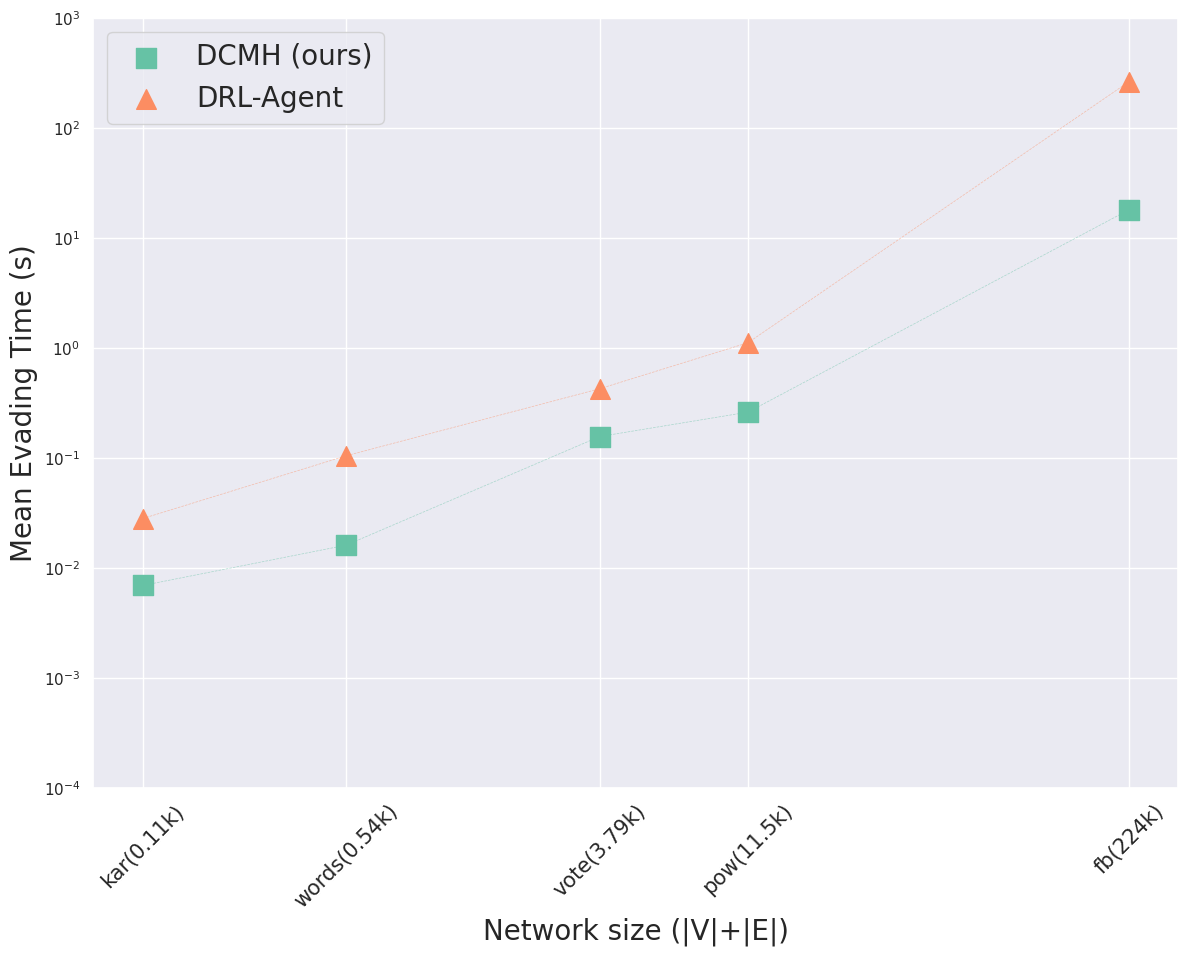

In [8]:
plot_time_all_datasets(
            datasets= [FilePaths.KAR.value,FilePaths.WORDS.value, FilePaths.VOTE.value, FilePaths.POW.value, FilePaths.FB_75.value],
            detection_algs= [ DetectionAlgorithmsNames.GRE.value, DetectionAlgorithmsNames.LOUV.value,DetectionAlgorithmsNames.WALK.value],
            taus=[0.5],
            betas=[0.5,1,2],
        )